# Boat Object Detection with YOLO

In this exercise, you will fine-tune a YOLO model for boat detection in satellite imagery.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd

## Data Collection

Download the training and test datasets.

In [2]:
download = 1 # Set "download = None" if you have not already downloaded the files

In [3]:
if download is None:
    # URLs for the dataset files
    data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
    data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
    data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

    def download_file(url, file_name):
        response = requests.get(url)
        response.raise_for_status()
        with open(file_name, 'wb') as file:
            file.write(response.content)
        print(f'Downloaded {file_name}')

    # Download the files
    download_file(data_train_features_url, 'X_train.pkl')
    download_file(data_train_labels_url, 'y_train.pkl')
    download_file(data_test_features_url, 'X_test.pkl')

In [4]:
# Load the training data
with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format - class_id, x_center, y_center, width, height):\n{y[0]}")

Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format - class_id, x_center, y_center, width, height):
[[0.       0.659871 0.57177  0.109442 0.162679]]


## Data Visualization

Display sample images with bounding boxes.

In [5]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.imshow(image)
    height, width = image.shape[:2]
    
    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box
        
        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height
        
        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.axis('off')
    return ax

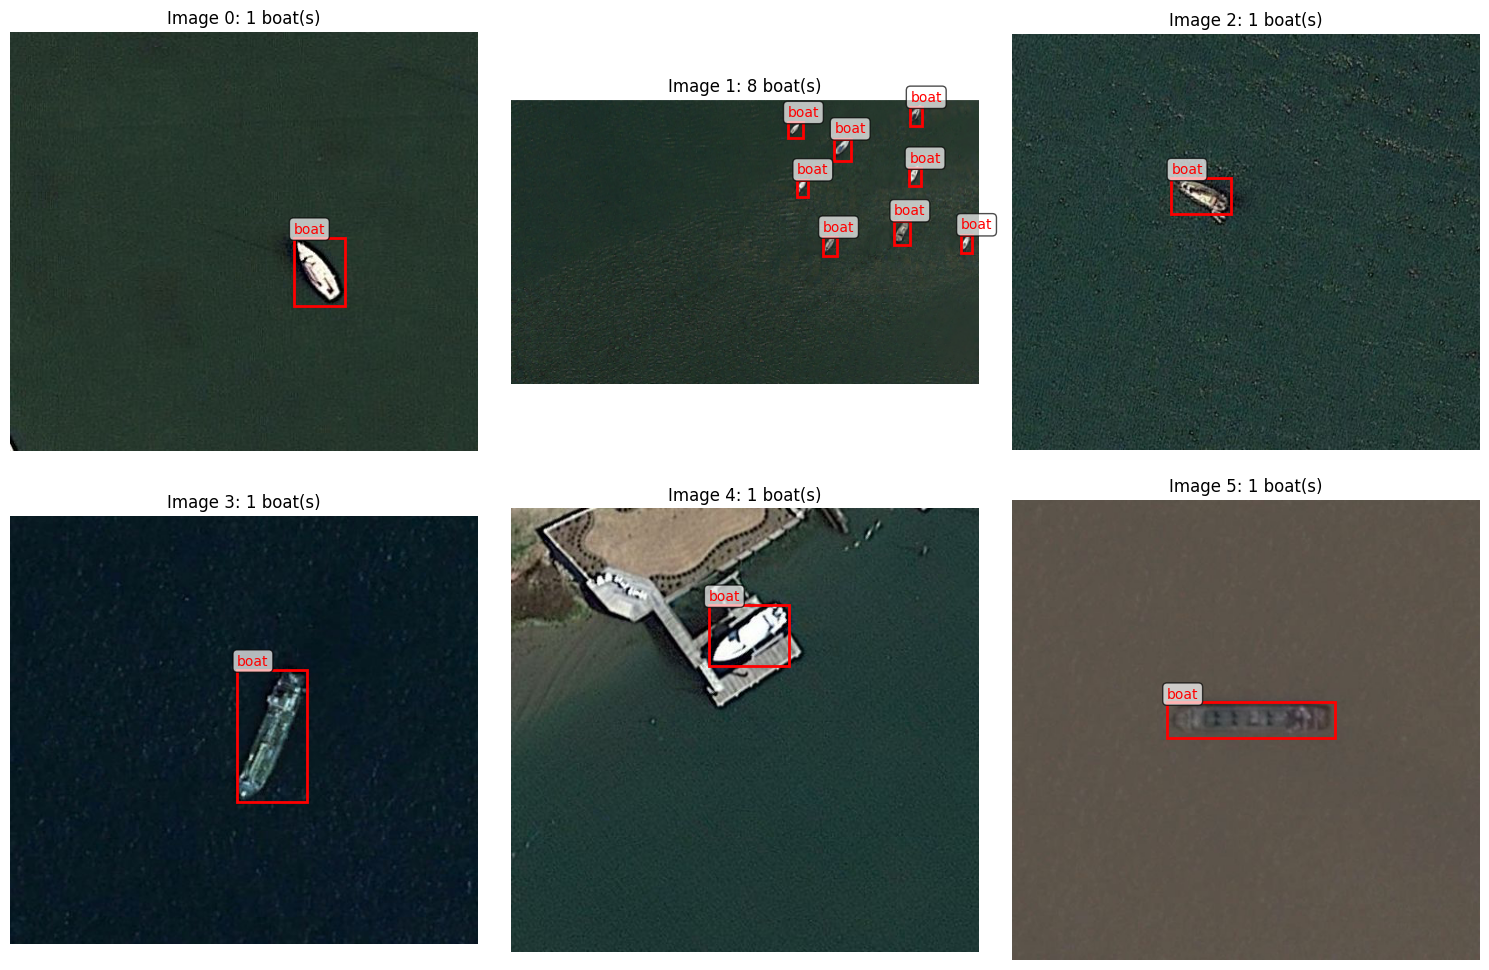

In [6]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')

plt.tight_layout()
plt.show()

## Model Setup

Load a pre-trained YOLO model and test it on the training images.

In [7]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

print("Model loaded successfully!")

Model loaded successfully!


In [8]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X[0])
sample_img.save('temp_sample.png')

# Run prediction
results = model.predict(source='temp_sample.png', conf=0.25)

print(f"Pre-trained model detected {len(results[0].boxes)} objects")
print("Note: The pre-trained model may not detect boats well - you need to fine-tune it!")


image 1/1 c:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\hugojava\module7\temp_sample.png: 576x640 1 tennis racket, 189.3ms
Speed: 4.8ms preprocess, 189.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 640)
Pre-trained model detected 1 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


## Fine-tune your YOLO model

Your task is to fine-tune the YOLO model on the boat detection dataset to achieve a mAP50 score of at least 0.73 on the test set.

In [9]:
# Your code here
# Fine-tune the YOLO model

### Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(X_val))
print(len(y_train), len(y_val))

396 100
396 100


### Creation of the files to be able to use the mAP50 metric

In [11]:
import os
import cv2
import yaml
import numpy as np

# === Configurations ===
# Tes données déjà chargées :
# X_train, y_train, X_val, y_val
# y_* = liste (ou array) de listes [label, x_center, y_center, height, width]
# toutes les coordonnées sont déjà normalisées entre 0 et 1

# Noms des classes
class_names = ['boat']  # ➜ change si tu as plusieurs classes

# Dossier de sortie
base_dir = "dataset_boats"
os.makedirs(base_dir, exist_ok=True)

# Sous-dossiers
splits = {
    "train": (X_train, y_train),
    "val": (X_val, y_val)
}

# === Sauvegarde images et labels ===
for split, (X, y) in splits.items():
    img_dir = os.path.join(base_dir, split, "images")
    label_dir = os.path.join(base_dir, split, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    print(f"\n➡️ Sauvegarde des données {split} ({len(X)} images) ...")

    for i, (img, labels) in enumerate(zip(X, y)):
        # Sauvegarde image
        img_path = os.path.join(img_dir, f"img_{i}.jpg")
        cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        # Sauvegarde labels (format YOLO)
        label_path = os.path.join(label_dir, f"img_{i}.txt")
        with open(label_path, "w") as f:
            for lab in np.atleast_2d(labels):  # gérer le cas 1 seule bbox
                cls, x, y_, w_, h = lab
                f.write(f"{int(cls)} {x:.6f} {y_:.6f} {w_:.6f} {h:.6f}\n")

print("\n✅ Images et labels sauvegardés avec succès !")

# === Création du fichier data.yaml ===
data_yaml = {
    "train": os.path.abspath(os.path.join(base_dir, "train/images")),
    "val": os.path.abspath(os.path.join(base_dir, "val/images")),
    "nc": len(class_names),
    "names": class_names
}

yaml_path = os.path.join(base_dir, "data.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"\n✅ Fichier data.yaml créé : {yaml_path}")
print("\nContenu du fichier :")
print(yaml.dump(data_yaml, default_flow_style=False))


➡️ Sauvegarde des données train (396 images) ...

➡️ Sauvegarde des données val (100 images) ...

✅ Images et labels sauvegardés avec succès !

✅ Fichier data.yaml créé : dataset_boats\data.yaml

Contenu du fichier :
names:
- boat
nc: 1
train: "c:\\Users\\tbout\\Documents\\Sorbonne\\DataScience\\RepoG\xE9n\xE9ral\\data_science_practice_2025\\\
  hugojava\\module7\\dataset_boats\\train\\images"
val: "c:\\Users\\tbout\\Documents\\Sorbonne\\DataScience\\RepoG\xE9n\xE9ral\\data_science_practice_2025\\\
  hugojava\\module7\\dataset_boats\\val\\images"



### Display of boxes dimensions

In [12]:
import numpy as np
import glob

all_labels = glob.glob(os.path.join(base_dir, "train/labels/*.txt"))

for label_file in all_labels[:5]:  # 5 premiers fichiers
    data = np.loadtxt(label_file)
    if data.ndim == 1:
        data = data[None, :]
    cls, x, y, w, h = data.T
    print(f"\n{os.path.basename(label_file)}")
    print(f"  x∈[{x.min():.2f}, {x.max():.2f}]")
    print(f"  y∈[{y.min():.2f}, {y.max():.2f}]")
    print(f"  w∈[{w.min():.2f}, {w.max():.2f}]")
    print(f"  h∈[{h.min():.2f}, {h.max():.2f}]")


img_0.txt
  x∈[0.38, 0.38]
  y∈[0.46, 0.46]
  w∈[0.06, 0.06]
  h∈[0.14, 0.14]

img_1.txt
  x∈[0.37, 0.37]
  y∈[0.39, 0.39]
  w∈[0.17, 0.17]
  h∈[0.10, 0.10]

img_10.txt
  x∈[0.31, 0.31]
  y∈[0.28, 0.28]
  w∈[0.22, 0.22]
  h∈[0.14, 0.14]

img_100.txt
  x∈[0.54, 0.54]
  y∈[0.52, 0.52]
  w∈[0.23, 0.23]
  h∈[0.15, 0.15]

img_101.txt
  x∈[0.55, 0.55]
  y∈[0.52, 0.52]
  w∈[0.22, 0.22]
  h∈[0.15, 0.15]


### Display of boxes on the dataset images


🖼️ Vérification des annotations sur quelques images (396 disponibles)...
→ dataset_boats\train\images\img_0.jpg


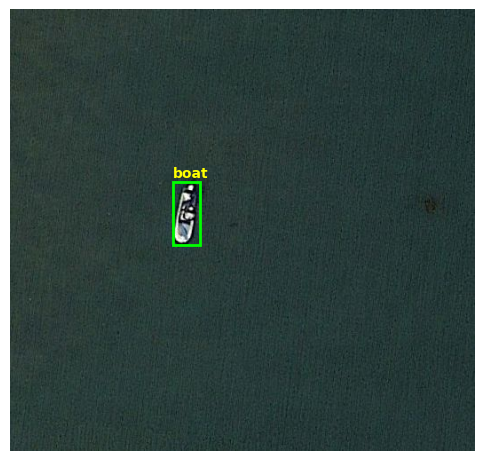

→ dataset_boats\train\images\img_1.jpg


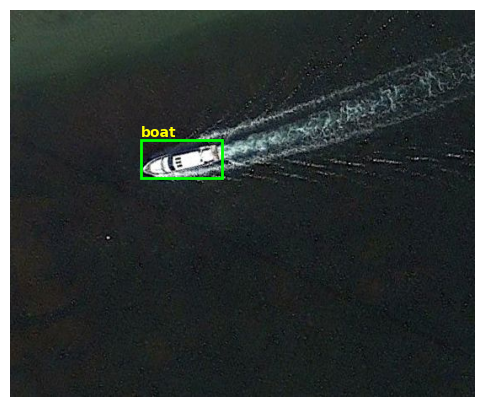

→ dataset_boats\train\images\img_10.jpg


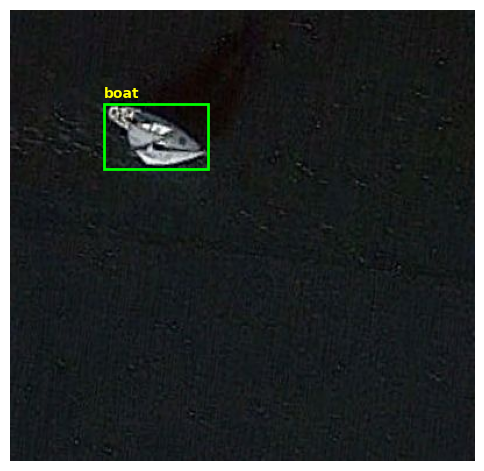

In [13]:
import matplotlib.pyplot as plt

# === Vérification visuelle des annotations YOLO ===
def show_yolo_labels(image_path, label_path, class_names):
    """Affiche une image et ses bounding boxes YOLO."""
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Charger les labels (classe, x_center, y_center, width, height)
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                # Convertir en coordonnées absolues
                x1 = int((xc - bw / 2) * w)
                y1 = int((yc - bh / 2) * h)
                x2 = int((xc + bw / 2) * w)
                y2 = int((yc + bh / 2) * h)
                boxes.append((int(cls), x1, y1, x2, y2))

    # Afficher l’image et les boîtes
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    for cls, x1, y1, x2, y2 in boxes:
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                          fill=False, color='lime', linewidth=2)
        )
        plt.text(x1, y1 - 5, class_names[cls],
                 color='yellow', fontsize=10, weight='bold')
    plt.axis('off')
    plt.show()

# === Exemple d'affichage ===
# Choisis une ou plusieurs images à vérifier (train ou val)
sample_dir = os.path.join(base_dir, "train")
sample_images = os.listdir(os.path.join(sample_dir, "images"))

print(f"\n🖼️ Vérification des annotations sur quelques images ({len(sample_images)} disponibles)...")

for i in range(min(3, len(sample_images))):  # affiche les 3 premières
    img_path = os.path.join(sample_dir, "images", sample_images[i])
    label_path = os.path.join(sample_dir, "labels", sample_images[i].replace(".jpg", ".txt"))
    print(f"→ {img_path}")
    show_yolo_labels(img_path, label_path, class_names)

### Evaluate the Pre-trained model on the validation set

In [14]:
metrics_pre_trained = model.val(data='dataset_boats/data.yaml', verbose=False)

print(f"mAP@0.5: {metrics_pre_trained.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics_pre_trained.box.map:.3f}")
print(f"Precision: {metrics_pre_trained.box.mp:.3f}")
print(f"Recall: {metrics_pre_trained.box.mr:.3f}")

Ultralytics 8.3.214  Python-3.13.7 torch-2.8.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)
val: Fast image access  (ping: 0.00.0 ms, read: 469.9318.8 MB/s, size: 52.5 KB)
val: Scanning C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGénéral\data_science_practice_2025\hugojava\module7\dataset_boats\val\labels... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 1.2Kit/s 0.1s
val: New cache created: C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\hugojava\module7\dataset_boats\val\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 0.6it/s 12.6s2.3s
                   all        100        160     0.0807        0.6      0.178     0.0945
Speed: 1.5ms preprocess, 112.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\runs\detect\val33
mAP@0.5: 0.178
mAP@0.5:0.95: 0.095
P

### Data augmentation

In [15]:
def save_yolo_label(label_path_out, cls, xc, yc, w, h):
    with open(label_path_out, "a") as f:
        f.write(f"{int(cls)} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

def horizontal_flip(img, boxes):
    # boxes: list of [cls, xc, yc, w, h] normalized
    out_boxes = []
    for cls, xc, yc, w_, h_ in boxes:
        xc_f = 1.0 - xc
        out_boxes.append([cls, xc_f, yc, w_, h_])
    return img[:, ::-1, :], out_boxes

def change_brightness(img, factor):
    img2 = img.astype(np.float32) * factor
    img2 = np.clip(img2, 0, 255).astype(np.uint8)
    return img2

def augment_dataset(split_dir, how_many=1):
    img_dir = os.path.join(split_dir, "images")
    lbl_dir = os.path.join(split_dir, "labels")
    out_img_dir = os.path.join(split_dir, "images_aug")
    out_lbl_dir = os.path.join(split_dir, "labels_aug")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    idx = 0
    for fname in files:
        img_path = os.path.join(img_dir, fname)
        base = os.path.splitext(fname)[0]
        lbl_path = os.path.join(lbl_dir, base + ".txt")

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        # load boxes
        boxes = []
        if os.path.exists(lbl_path):
            with open(lbl_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5: continue
                    cls, xc, yc, wb, hb = map(float, parts)
                    boxes.append([cls, xc, yc, wb, hb])

        # Save original into aug folders too
        out_img_name = f"aug_{idx}_{fname}"
        cv2.imwrite(os.path.join(out_img_dir, out_img_name), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        # write labels
        if boxes:
            with open(os.path.join(out_lbl_dir, out_img_name.replace('.jpg','.txt')), "w") as f:
                for cls, xc, yc, w_, h_ in boxes:
                    f.write(f"{int(cls)} {xc:.6f} {yc:.6f} {w_:.6f} {h_:.6f}\n")
        idx += 1

        # Horizontal flip
        img_f, boxes_f = horizontal_flip(img, boxes)
        out_img_name = f"aug_{idx}_hflip_{fname}"
        cv2.imwrite(os.path.join(out_img_dir, out_img_name), cv2.cvtColor(img_f, cv2.COLOR_RGB2BGR))
        if boxes_f:
            with open(os.path.join(out_lbl_dir, out_img_name.replace('.jpg','.txt')), "w") as f:
                for cls, xc, yc, w_, h_ in boxes_f:
                    f.write(f"{int(cls)} {xc:.6f} {yc:.6f} {w_:.6f} {h_:.6f}\n")
        idx += 1

        # Brightness variations (two factors)
        for factor in [0.8, 1.2]:
            img_b = change_brightness(img, factor)
            out_img_name = f"aug_{idx}_bright{factor}_{fname}"
            cv2.imwrite(os.path.join(out_img_dir, out_img_name), cv2.cvtColor(img_b, cv2.COLOR_RGB2BGR))
            # same boxes
            if boxes:
                with open(os.path.join(out_lbl_dir, out_img_name.replace('.jpg','.txt')), "w") as f:
                    for cls, xc, yc, w_, h_ in boxes:
                        f.write(f"{int(cls)} {xc:.6f} {yc:.6f} {w_:.6f} {h_:.6f}\n")
            idx += 1

    print(f"Augmented images written to {out_img_dir} and labels to {out_lbl_dir}")

In [16]:
# === Appliquer les augmentations sur le dossier train ===
augment_dataset("dataset_boats/train")

Augmented images written to dataset_boats/train\images_aug and labels to dataset_boats/train\labels_aug


In [17]:
import shutil, os
import random

# Fusionner images augmentées dans les dossiers d'origine
for sub in ["images", "labels"]:
    src = os.path.join("dataset_boats/train", f"{sub}_aug")
    dst = os.path.join("dataset_boats/train", sub)
    for fname in os.listdir(src):
        if random.random() < 0.5:  # 50% de chance d’ajouter l'image
            shutil.copy(os.path.join(src, fname), os.path.join(dst, fname))

print("✅ Fusion terminée — environ 50% des images augmentées ont été ajoutées au dataset train !")

✅ Fusion terminée — environ 50% des images augmentées ont été ajoutées au dataset train !


### Fine-tuning

In [18]:
# Load a pre-trained YOLOv8 model (nano version)
model_2 = YOLO('yolov8n.pt')

In [ ]:
# Réentraîner sur le dataset de bateaux
model_2.train(
    data='dataset_boats/data.yaml',
    epochs=20,
    imgsz=320,
    batch=8,      # nombre d'images traitées simultanément
    name='boat_yolov8n_lowpower',
    workers=0,    # évite la surchauffe CPU sur Windows
    device='cpu', # (optionnel) pour forcer l'utilisation du CPU
)

New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.214  Python-3.13.7 torch-2.8.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_boats/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=boat_yolov8n_lowpower10, nbs=64, nms=Fals

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021151791220>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### Evaluate the model on the validation set

In [20]:
metrics = model_2.val(data='dataset_boats/data.yaml', verbose=False)
print(f"mAP@0.5: {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")

Ultralytics 8.3.214  Python-3.13.7 torch-2.8.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 203.4143.0 MB/s, size: 52.0 KB)
val: Scanning C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGénéral\data_science_practice_2025\hugojava\module7\dataset_boats\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 74.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.6it/s 4.2s0.8ss
                   all        100        160      0.827      0.694      0.759      0.539
Speed: 0.4ms preprocess, 33.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\runs\detect\val34
mAP@0.5: 0.759
mAP@0.5:0.95: 0.539
Precision: 0.827
Recall: 0.694


mAP@0.5: 0.801
mAP@0.5:0.95: 0.569
Precision: 0.927
Recall: 0.716

We can improve the mAP50 by increasing the number of epochs and the size of the image.

## Generate Predictions for Test Set

Generate predictions on the test set and save them in the required CSV format.

In [21]:
# Load test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X_test)} test images")

Loaded 125 test images


In [29]:
# Generate predictions on test set
# Your trained model should be used here
# Format: CSV with columns: image_id, box_idx, class_id, confidence, x_center, y_center, width, height

predictions = []

for img_idx, img in enumerate(X_test):
    # Save image temporarily
    temp_img = Image.fromarray(img)
    temp_img.save('temp_test.png')
    
    # Run prediction with your fine-tuned model
    # Replace 'model' with your fine-tuned model
    results = model_2.predict(source='temp_test.png', conf=0.4, verbose=False)
    
    # Extract predictions
    for box_idx, box in enumerate(results[0].boxes):
        # Get box data in YOLO format (normalized coordinates)
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())
        
        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,  # Always 0 for boat
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })
    
    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 135


torch.Size([1, 6])


<Axes: >

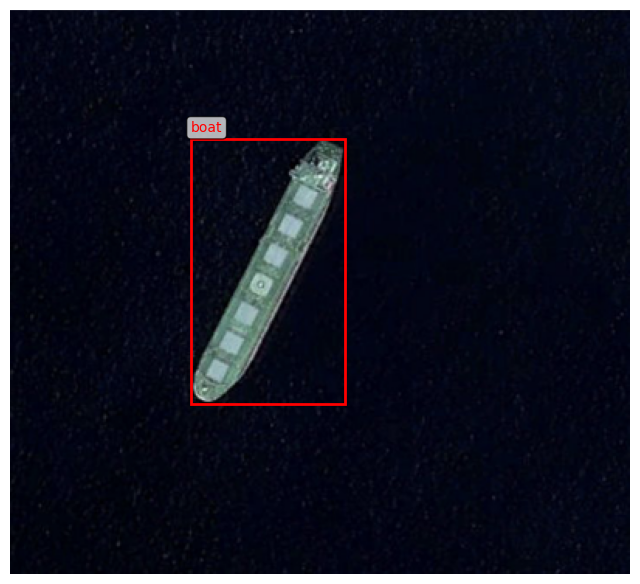

In [38]:
# prediction of the test set
pred_0 = predictions[53]
image_0 = X_test[pred_0["image_id"]]
box_0 = np.array([pred_0["class_id"], pred_0["x_center"], pred_0["y_center"], pred_0["width"], pred_0["height"]]).reshape(1,-1)
print(box.shape)
plot_image_with_boxes(image_0, box_0)

In [40]:
# Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print("\nFirst few predictions:")
print(df_predictions.head(10))

Predictions saved to predictions.csv

First few predictions:
   image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         0        0         0    0.717654  0.564633  0.435824  0.159493   
1         2        0         0    0.519301  0.474235  0.422336  0.307711   
2         3        0         0    0.577835  0.361248  0.360257  0.234193   
3         4        0         0    0.473045  0.464290  0.418457  0.122176   
4         5        0         0    0.587079  0.428407  0.452999  0.354617   
5         6        0         0    0.588611  0.575949  0.548366  0.455966   
6         8        0         0    0.739091  0.592012  0.480680  0.177738   
7         9        0         0    0.542710  0.555380  0.528046  0.196414   
8        10        0         0    0.570413  0.363253  0.418812  0.436782   
9        12        0         0    0.586235  0.630875  0.584458  0.280702   

     height  
0  0.127399  
1  0.219328  
2  0.128916  
3  0.440877  
4  0.497736  
5  0.514724  
6  0